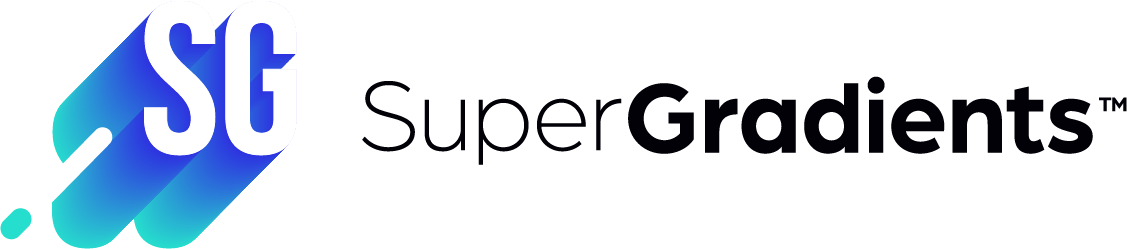

In [4]:
!kaggle competitions download -c kitchenware-classification
!mkdir data
!unzip kitchenware-classification.zip -d data > /dev/null
!rm kitchenware-classification.zip

100%|██████████████████████████████████████| 1.63G/1.63G [00:27<00:00, 83.9MB/s]
100%|██████████████████████████████████████| 1.63G/1.63G [00:27<00:00, 64.2MB/s]
mkdir: cannot create directory ‘data’: File exists


In [1]:
import os
import numpy as np 
import pandas as pd
import torch
import torchvision
import super_gradients
from pathlib import Path, PurePath

from PIL import Image
import pprint
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision.transforms import Resize
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from super_gradients import init_trainer, Trainer
from super_gradients.common import MultiGPUMode
from super_gradients.training.utils.distributed_training_utils import setup_gpu_mode
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams

from super_gradients.training import models
from super_gradients import Trainer

You did not mention an AWS environment.You can set the environment variable ENVIRONMENT_NAME with one of the values: development,staging,production
deci_platform_sg_logger -WARNING- Failed to import deci_lab_client
callbacks -WARNING- Failed to import deci_lab_client
quantization_utils -WARNING- Failed to import pytorch_quantization
env_sanity_check -INFO- ** A sanity check is done when importing super_gradients for the first time. **
-> You can see the details by setting the env variable DISPLAY_SANITY_CHECK=True prior to import.


SuperGradients has a number of pretrained models for image classification tasks (object detection and segmentation, too!). Check out the [model zoo ](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/Computer_Vision_Models_Pretrained_Checkpoints.md) to see all the pretrained models available to you.

You can also view the model architectures available to you:

In [3]:
# uncomment the following line to see the architectures available to you
# list(models.ARCHITECTURES.keys())

You'll use the base ViT (vision transformer) for this starter notebook, but you're encouraged to experiment with different models to see which work.

The config class will help you keep track of values you will use through this notebook. When you experiment with different models you will need to replace `MODEL_NAME` and `TRAINING_PARAMS` in the config class with the appropriate values. You can examine the print outs above and select from there.

In [5]:
class config:
    EXPERIMENT_NAME = 'kitchenware_classification'
    MODEL_NAME = 'vit_base'
    CHECKPOINT_DIR = 'checkpoints'
    WEIGHTS = "imagenet"
    TRAINING_PARAMS = "training_hyperparams/imagenet_vit_train_params"
    NUM_CLASSES = 6
    BATCH_SIZE = 16

    # specify the paths to training and validation set 
    IMAGE_PATH = 'data/images'
    TRAIN_DATA = 'data/train.csv'
    TEST_DATA = 'data/test.csv'

    

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    # set the input height and width
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    NUM_WORKERS = os.cpu_count()

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate, SG Trainer, model, and training params

The following cell will initialize your trainer. 

The trainer is in charge things like training, evaluation, saving checkpoints, plotting etc. `experiment_name` the most important argument for the trainer. All checkpoints, logs and tensorboards will be saved in a directory with it'the same name.

The model is also instantiated here.

All SG models are PyTorch nn.modules. Notice that all you have to do to replace the classification head is pass the number of classes in your usecase to the `num_classes` argument, SuperGradients will take care of the rest for you. You can either train the model from scratch, or use a pretrained model. 

You use a pretrained model by passing in a value for the `pretrained_weights` argument, in this case it's ImageNet.


In [6]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

model = models.get(model_name=config.MODEL_NAME, num_classes=config.NUM_CLASSES, pretrained_weights=config.WEIGHTS)

Downloading: "https://deci-pretrained-models.s3.amazonaws.com/vit_base_imagenet1k/ckpt_best.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vit_base_imagenet1k_ckpt_best.pth


  0%|          | 0.00/661M [00:00<?, ?B/s]

## SuperGradients offers you a number of training tricks out of the box, such as:

1) Exponential Moving Average – EMA

2) Weight Averaging

3) Batch Accumulation

4) Precise BatchNorm

5) Zero-weight Decay on BatchNorm and Bias

To learn more about these tips and tricks, check out [this](https://www.deeplearningdaily.community/t/tips-for-training-your-neural-networks/307) article in the Deep Learning Daily community.

For illustration purposes in this starter all these tricks will be enabled. However, you are encouraged to experiment with them! Leave some values as defaults, turn on one at a time, turn on two and leave the others off. However you choose to experiment, please do.

If you have any questions, computer vision experts from Deci are available for advice in the Deep Learning Daily community. 

Feel free to come by and ask your questions.

In [7]:
training_params =  training_hyperparams.get(config.TRAINING_PARAMS)

# You can view all the options available to you by uncommenting the below
# training_params

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/super_gradients/training/training_hyperparams/training_hyperparams.py:24: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=pkg_resources.resource_filename("super_gradients.recipes", "")):
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'training_hyperparams/imagenet_vit_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


You can get a detailed description of what all these mean and available options by going [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).

In [8]:
# leaving it at a low number for demo purposes, you should make this bigger as big as 100 epochs
training_params["max_epochs"] = 1

# enable zero weight decay in batch norm and bias
training_params["zero_weight_decay_on_bias_and_bn"] = True

# this challenge only has 6 classes, monitoring top 5 accuracy won't make sence. monitor only accuracy
training_params['train_metrics_list'] = ['Accuracy']
training_params['valid_metrics_list'] = ['Accuracy']

# enable exponential moving average, it's turned off by default
training_params['ema'] = True

# you can also experiment with the parameters for EMA
# training_params['ema_params']: {'decay': 0.9999, 'beta': 15, 'exp_activation': True}

# Enable label-smoothing cross-entropy, you can experiment with the values for smooth_eps
training_params["criterion_params"] = {'smooth_eps': 0.1} 

# enable checkpoint averaging, it's turned off by default
training_params['average_best_models'] = True

# no launch of tensorboard
training_params["sg_logger_params"]["launch_tensorboard"] = False

# precise batchnorm is turned off by default, you can toggle to True and examine your results
# training_params["precise_bn"] = False 

# if you choose to use precise batch norm you will also need to specify the size
# training_params['precise_bn_batch_size']= None

#  You can change the initial learning rate to some other value if you'd like
# training_params['initial_lr']= 0.03

# Split training data into train and validation sets

In [9]:
def add_image_col(df):
    df['image'] = df['Id'].apply(lambda x: x +'.jpg')
    
# read labels into pandas df all cols as string
labels_df = pd.read_csv(config.TRAIN_DATA, dtype='str')
test_df = pd.read_csv(config.TEST_DATA, dtype='str')

# create col (xxxx.jpg), the image filename
add_image_col(labels_df)
add_image_col(test_df)

# map labels to integer
le = LabelEncoder()
labels_df['targets'] = le.fit_transform(labels_df['label'])

#split into train and validation sets
train_df, val_df = train_test_split(labels_df,  stratify= labels_df['targets'], test_size=.10, shuffle=True, random_state=42)

# number of samples in each
train_df.shape[0] , val_df.shape[0], test_df.shape[0]

(5003, 556, 3808)

# DataLoaders and Augmentations

A neural network will learn what it observes in the data. 

This could be widly different than what you, as a human, observes. If there are statistical associations present in your training data, the network will learn those instead of what you want it to learn. Let's think about this, I want you to imagine Santa Claus.

What color is that Santa?

A well-known fact is that Santa typically wears red. But you don't want your model to take shortcuts and just predict that anything red is Santa. That's why it is important to add color augementations: to prevent your model from finding these types of shortcuts. 

This is especially important when dealing with smaller datasets.

The following are a few categories of image augmentations

### **Spatial** 

These augmentations involve flipping an image (either horizontally or vertically), taking random crops of an image, rotataing the image by some number of degrees, shifting an image translating an image, or injecting noise into an image.

### **Photometric** 

These types of augmentations involve altering the brightness, hue, or color saturation of an inmage. You can also shuffle the color channels, emboss an image, play around with it's lighting (ISO noise), compress, or distort an image.

### **Kernel methods**

These augmentations typically mess around with the level of detail an image has by either making it more blurred or sharpening it. 

### **Deletion methods** 

Here you're randomly removing parts of an image. Whether it's dropping out a few random pixels, cutting out whole chunks of an image, etc. These techniques are supposed to help your classification model be more robust to occulusion. 

[This](https://towardsdatascience.com/complete-guide-to-data-augmentation-for-computer-vision-1abe4063ad07) amazing blog post by [Olga Chernytska](https://www.linkedin.com/in/olga-chernytska-122700102/) goes deep into why, when, and where to use image augmentations.

This image from her post shows what those augmentations look like (note that the "Flip" labels are swapped, but the rest of the image is correct):

<img src='https://miro.medium.com/max/1400/1*9wSxqFHWFJ-5tgYLaTanqQ.webp'>

Olga goes on to outline three considerations to make when selecting image augmentations:

1. Domain expertise
2. Business need
3. Common sense

She also shares the following heuristics:

* If you are worried about distortions to objects in your image then you can use cropping, rotations, reflections, and scaling.

* If you're working with medical images then you can use color transformations, grid distortion, and elastic transform.

* You shouldn't use vertical flip if you're never going to see upside versions of things in production.

* Be careful not to use too many augmentations.


---

### For classification of household kitchenware items, the following examples make sense:

#### Spatial augmentations 
* Rotations
* Flips
* Transposes
* Shear
* Non-uniform scaling
* Crops

#### Photometric augmentations
* ISO Noise
* Brightness / Contrast
* Image compression
* Image distortions

These augmentations will be applied using the [albumentations package](https://albumentations.ai/docs/api_reference/full_reference/).


# Dataloader

In [10]:
class KitchwareDataset(Dataset):
    def __init__(self, dataframe , img_dir, split, transform = None):
        self.img_labels = dataframe 
        self.img_dir = img_dir
        self.split = split
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self , idx):
        if self.split in ['train', 'val']:
            img_path = os.path.join(self.img_dir , self.img_labels.iloc[idx, 2])
            label = self.img_labels.iloc[idx, 3]
        else:
            img_path = os.path.join(self.img_dir , self.img_labels.iloc[idx, 1])
            
        original_image = Image.open(img_path)
        image = np.array(original_image)
        
        if self.transform:
            image = self.transform(image=image)['image']
            
        if self.split in ['train', 'val']: 
            return image, label 
        else:
            return image

# Transformations

You can see the full list of transformations in Albumentations [here](https://albumentations.ai/docs/api_reference/full_reference/). 

I'll instantiate a few transformations for you and I encourage you to check out the documentation and try out some more.

In [11]:
# initialize our data augmentation functions
make_tensor = ToTensorV2()

normalize = A.Normalize(mean=config.IMAGENET_MEAN, 
                        std=config.IMAGENET_STD)

resize = A.Resize(height=config.INPUT_HEIGHT,
                  width=config.INPUT_WIDTH)

horizontal_flip = A.HorizontalFlip(p=0.50)

flip = A.Flip(p=0.50)

random_ninety = A.RandomRotate90()

random_crop = A.RandomCrop(height=config.INPUT_HEIGHT,
                           width=config.INPUT_WIDTH,
                           p=0.75)

hue_saturation = A.HueSaturationValue(p=.5)

iso_noise = A.ISONoise(p=.5)

color_jitter = A.ColorJitter(p=.5)

emboss = A.Emboss(p=.5)

channel_shuffle = A.ChannelShuffle(p=.5)

randomly_choose_one = A.OneOf([flip, 
                               random_ninety, 
                               iso_noise,
                               color_jitter,
                               emboss,
                               hue_saturation,
                               channel_shuffle], p=.50)

# initialize our training and validation set data augmentation pipeline
train_transforms = A.Compose([
  resize, 
  horizontal_flip, 
  random_crop,
  randomly_choose_one,
  normalize,
  make_tensor
])

val_transforms = A.Compose([resize, normalize, make_tensor])

In [12]:
train_data = KitchwareDataset(train_df , config.IMAGE_PATH , 'train', transform = train_transforms)
val_data = KitchwareDataset(val_df , config.IMAGE_PATH , 'val', transform = val_transforms)
test_data = KitchwareDataset(test_df, config.IMAGE_PATH, 'test',transform = val_transforms)

train_dataloader = DataLoader(train_data, batch_size = config.BATCH_SIZE , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = config.BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = config.BATCH_SIZE, shuffle = False)

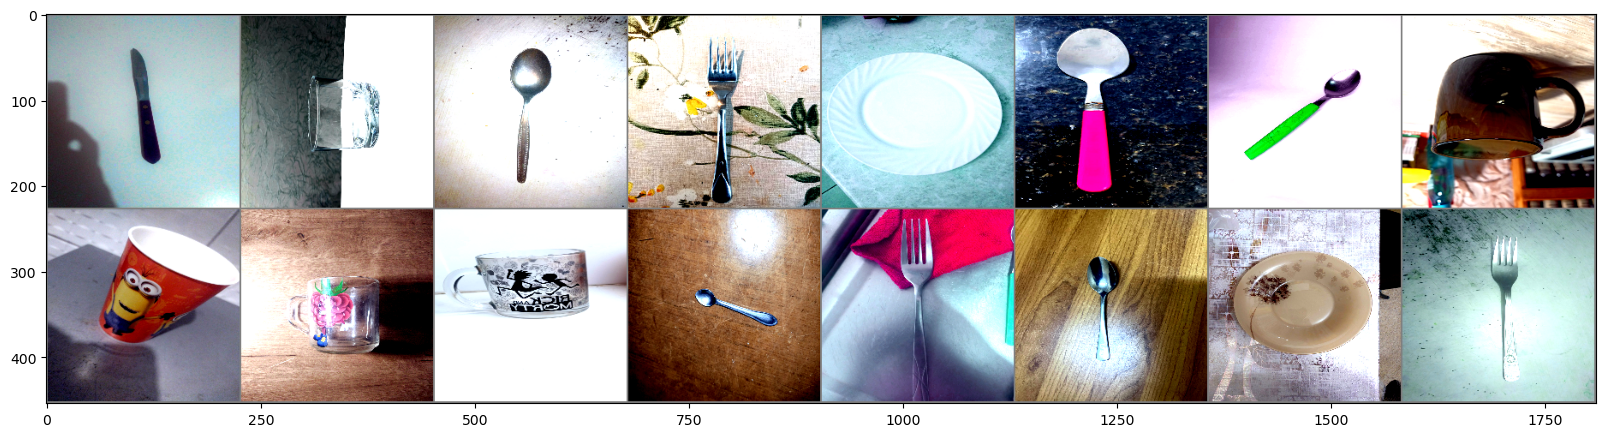

In [13]:
def show_img(img):
    plt.figure(figsize=(20,16))
    img = img * 0.5 + 0.5  
    npimg = np.clip(img.numpy(), 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data = iter(train_dataloader)
images, labels = data.next()
show_img(torchvision.utils.make_grid(images))

In [14]:
trainer.train(model=model, 
              training_params=training_params, 
              train_loader=train_dataloader,
              valid_loader=val_dataloader)

sg_trainer -INFO- Using EMA with params {'decay': 0.9999, 'beta': 15, 'exp_activation': True}
optimizer_utils -WARNING- Module class: <class 'torch.nn.modules.normalization.LayerNorm'>, have a `bias` parameter attribute but is not instance of torch primitive modules, this bias parameter will be part of param group with zero weight decay.
optimizer_utils -WARNING- Module class: <class 'torch.nn.modules.normalization.LayerNorm'>, have a `bias` parameter attribute but is not instance of torch primitive modules, this bias parameter will be part of param group with zero weight decay.
optimizer_utils -WARNING- Module class: <class 'torch.nn.modules.normalization.LayerNorm'>, have a `bias` parameter attribute but is not instance of torch primitive modules, this bias parameter will be part of param group with zero weight decay.
optimizer_utils -WARNING- Module class: <class 'torch.nn.modules.normalization.LayerNorm'>, have a `bias` parameter attribute but is not instance of torch primitive mod

Train epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/torch/cuda/memory.py:384: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
Validation epoch 0: 100%|██████████| 35/35 [00:13<00:00,  2.59it/s]


SUMMARY OF EPOCH 0
├── Training
│   └── Labelsmoothingcrossentropyloss = 0.5598
└── Validation
    ├── Accuracy = 0.9676
    └── Labelsmoothingcrossentropyloss = 0.5032

base_sg_logger -INFO- Checkpoint saved in checkpoints/kitchenware_classification/ckpt_best.pth
sg_trainer -INFO- Best checkpoint overriden: validation Accuracy: 0.9676259160041809
sg_trainer -INFO- RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...


Validation epoch 1: 100%|██████████| 35/35 [00:15<00:00,  2.27it/s]

SUMMARY OF EPOCH 1
├── Training
│   └── Labelsmoothingcrossentropyloss = 0.5598
└── Validation
    ├── Accuracy = 0.9676
    │   ├── Best until now = 0.9676 (↘ 0.0)
    │   └── Epoch N-1      = 0.9676 (↘ 0.0)
    └── Labelsmoothingcrossentropyloss = 0.5032
        ├── Best until now = 0.5032 (↘ 0.0)
        └── Epoch N-1      = 0.5032 (↘ 0.0)



In [15]:
# Load the best model that we trained
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

# Predict on test set and submit


In [ ]:
all_predictions = []
best_model.eval()
with torch.inference_mode():
    for index, batch in enumerate(test_dataloader):
        results = best_model(batch)
        soft_max = torch.softmax(results, dim=1)
        label = torch.argmax(soft_max, dim=1)
        transformed_labels = le.inverse_transform(label.numpy())
        all_predictions.extend(transformed_labels)

In [ ]:
test_df['label'] = all_predictions
test_df.drop(columns=['image'], inplace=True)
test_df.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit kitchenware-classification -f submission.csv -m 'supergradient'

# Experiment tracking

SuperGradients also has integrations with experiment tracking tools like Weights & Biases and ClearML. 

### To integrate with Weights & Biases:

```
from super_gradients import Trainer

# create a trainer object, look the declaration for more parameters
trainer = Trainer("experiment_name")

train_params = { ... # training parameters
                "sg_logger": "wandb_sg_logger", # Weights&Biases Logger, see class WandBSGLogger for details
                "sg_logger_params": # paramenters that will be passes to __init__ of the logger 
                  {
                    "project_name": "project_name", # W&B project name
                    "save_checkpoints_remote": True
                    "save_tensorboard_remote": True
                    "save_logs_remote": True
                  } 
               }
```

### To integrate with ClearML

```
from super_gradients import Trainer

# create a trainer object, look the declaration for more parameters
trainer = Trainer("experiment_name")

train_params = { ... # training parameters
                "sg_logger": "clearml_sg_logger", # ClearML Logger, see class ClearMLSGLogger for details
                "sg_logger_params": # paramenters that will be passes to __init__ of the logger 
                  {
                    "project_name": "project_name", # ClearML project name
                    "save_checkpoints_remote": True,
                    "save_tensorboard_remote": True,
                    "save_logs_remote": True,
                  } 
               }
```

# I'm looking forward to your results! If you have any questions, don't hesitate to ask in the [Deep Learning Daily community forum](https://www.deeplearningdaily.community/). 

## Don't forget to [leave a star](https://github.com/Deci-AI/super-gradients) for the SuperGradients repository!